In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as interp
import utm

In [3]:
# mag_path = 'data/mag_data.csv'
gps_path = 'data/gps.csv'

# mag_data = pd.read_csv(mag_path)
gps_data = pd.read_csv(gps_path)

utm_lat, utm_lon, zone_num, zone_letter = utm.from_latlon(gps_data['Latitude'].to_numpy(), gps_data['Longitude'].to_numpy())

In [13]:
# display(utm_lat%1000)
# display(utm_lon%1000)

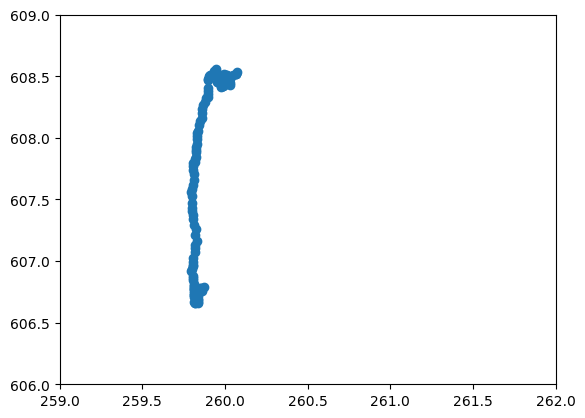

In [20]:
plt.scatter(utm_lat%1000, utm_lon%1000)
plt.ylim(606,609)
plt.xlim(259,262)
plt.show()